In [10]:
import os
import pandas as pd

In [15]:
## all my csv (the namefile starting with a number)
files = [i for i in os.listdir('other_data/') if i[0].isdigit()]


## Initializing all csv files as a pandas dataframe
def setup(datalist):
    
    dfs = []
    for i in datalist:  
        try:
            dfs.append(pd.read_csv("other_data/" + str(i)))
        except UnicodeDecodeError:
            print(i)
    
    return dfs     

dfs = setup(files)


## Creating a list of pandas datetimes from the filenames 
def timestamps(datalist):
    periods = []
    for i in datalist:
        y = i.split(".")[0].split("_")[1]
        m = i.split(".")[0].split("_")[0]
        d = 1
        date = str(y) + "-" + str(m) + "-" + str(d)
        date = pd.Timestamp(date)
        periods.append(date)
    return periods

periods = timestamps(files)


## Sorting dataframes by date
tmp = [(d,p) for d,p in sorted(zip(dfs,periods), key=lambda pair: pair[1])]
periods = [b for a,b in tmp]

dfs = [a for a,b in tmp]
    
    
## then check out if everything went well 
assert(len(periods) == len(dfs))

In [16]:
## remove price outliers as usual

def remove_outliers(period):
    x = period['price'] * period['availability_365'] / 365
    period["price_pond"] = x
    y = period['price']
    return period[y.between(y.quantile(.0001), y.quantile(.97))]

dfs = [remove_outliers(i) for i in dfs]


## for a better readability

periods = [i.strftime('%Y/%m') for i in periods]

In [17]:
periods

['2018/07', '2019/02', '2019/07', '2020/02', '2020/08', '2020/10', '2020/12']

In [18]:
## make a column with macroarea value {"periferia", "centro"} 

def aggregate_zone(df):
    df["macroarea"] = 'periferia'
    df.loc[df['zone'].isin(['Marconi','Irnerio','Malpighi','Galvani']), 'macroarea'] = 'centro'
    return df

dfs = [aggregate_zone(i) for i in dfs]

/home/laszlo/my_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/laszlo/my_venv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
def prezzo_medio_per_zona(x1, x2, dfs=dfs):    
    
    y1 = dfs[x1].groupby("zone")['price'].mean()
    y2 = dfs[x2].groupby("zone")['price'].mean()

    s1 = ((y2 - y1) / y1 ) * 100
    s0 = s1.index

    for ix,it in enumerate(s0):
        print(f"tasso crescita prezzo medio fra {periods[x1]} e {periods[x2]} per quartiere {it} è del {s1[ix]:.2f} %")

    print()
    print(f"media {((y2.sum()- y1.sum()) / y1.sum() ) * 100}")


prezzo_medio_per_zona(0, 2)
print()
print()
prezzo_medio_per_zona(1, 3)
print()
print()
prezzo_medio_per_zona(3, 6)

tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Barca è del 6.77 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Bolognina è del 6.47 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Borgo Panigale è del 15.13 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Colli è del 3.89 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Corticella è del 16.57 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Costa Saragozza è del 13.86 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Galvani è del 4.61 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Irnerio è del 7.78 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Lame è del 15.74 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Malpighi è del 9.08 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere Marconi è del 10.47 %
tasso crescita prezzo medio fra 2018/07 e 2019

In [21]:
def prezzo_medio_per_macroarea(x1, x2, dfs=dfs):
    
    y1 =dfs[x1].groupby("macroarea")['price'].mean()
    y2 = dfs[x2].groupby("macroarea")['price'].mean()

    s1 = ((y2 - y1) / y1 ) * 100
    s0 = s1.index

    for ix,it in enumerate(s0):
        print(f"tasso crescita prezzo medio fra {periods[x1]} e {periods[x2]} per quartiere {it} è del {s1[ix]:.2f} %")
        
        
prezzo_medio_per_macroarea(0, 2)
print()
print()
prezzo_medio_per_macroarea(1, 3)
print()
print()
prezzo_medio_per_macroarea(3, 6)

tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere centro è del 8.15 %
tasso crescita prezzo medio fra 2018/07 e 2019/07 per quartiere periferia è del 6.91 %


tasso crescita prezzo medio fra 2019/02 e 2020/02 per quartiere centro è del 8.19 %
tasso crescita prezzo medio fra 2019/02 e 2020/02 per quartiere periferia è del 8.00 %


tasso crescita prezzo medio fra 2020/02 e 2020/12 per quartiere centro è del -3.10 %
tasso crescita prezzo medio fra 2020/02 e 2020/12 per quartiere periferia è del 2.20 %


In [23]:
def tasso_crescita_per_zona(x1, x2, dfs=dfs):   
    
    y1 =  dfs[x1]['zone'].value_counts(normalize=False)
    y2 = dfs[x2]['zone'].value_counts(normalize=False)

    s1 = ((y2 - y1) / y1 ) * 100
    s0 = s1.index

    for ix,it in enumerate(s0):
        print(f"tasso crescita num. annunci fra {periods[x1]} e {periods[x2]} per quartiere {it} è del {s1[ix]:.2f} %")
    
    print()
    print(f"media {((y2.sum() - y1.sum()) / y1.sum() ) * 100}")
    
tasso_crescita_per_zona(0, -3)
print()
print()
tasso_crescita_per_zona(-3, -1)

tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Barca è del 17.86 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Bolognina è del 1.40 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Borgo Panigale è del 7.35 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Colli è del 18.60 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Corticella è del 32.43 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Costa Saragozza è del -7.01 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Galvani è del 12.86 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Irnerio è del 20.33 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Lame è del 9.68 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Malpighi è del 8.78 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere Marconi è del 32.42 %
tasso crescita num. annunci fra 2018/07 e 20

In [24]:
def tasso_crescita_per_zona(x1, x2, dfs=dfs):   
    
    y1 = dfs[x1]['macroarea'].value_counts(normalize=False)
    y2 = dfs[x2]['macroarea'].value_counts(normalize=False)

    s1 = ((y2 - y1) / y1 ) * 100
    s0 = s1.index

    for ix,it in enumerate(s0):
        print(f"tasso crescita num. annunci fra {periods[x1]} e {periods[x2]} per quartiere {it} è del {s1[ix]:.2f} %")
    
    print()
    print(f"media {((y2.sum() - y1.sum()) / y1.sum() ) * 100}")
    
tasso_crescita_per_zona(0, -3)
print()
print()
tasso_crescita_per_zona(-3, -1)

tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere centro è del 20.01 %
tasso crescita num. annunci fra 2018/07 e 2020/08 per quartiere periferia è del 5.11 %

media 12.69331777064488


tasso crescita num. annunci fra 2020/08 e 2020/12 per quartiere centro è del -3.68 %
tasso crescita num. annunci fra 2020/08 e 2020/12 per quartiere periferia è del -1.58 %

media -2.7187985499741067


/home/laszlo/my_venv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


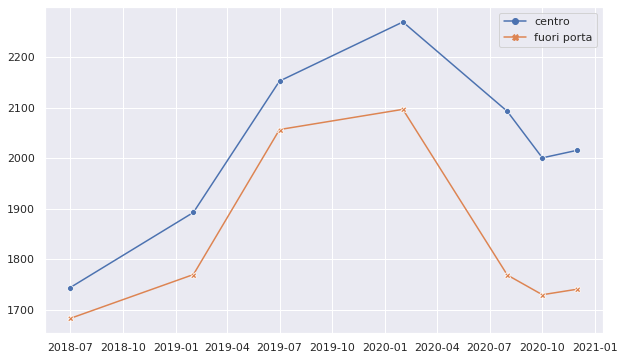

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


def snsplot(lines):
    sns.set(style="darkgrid")
    plt.figure(figsize=(10,6))
    sns.lineplot(markers=True, dashes=False, data=lines)


def ids_during_time(dfs, periods):
    index = pd.DatetimeIndex(periods)

    centro = pd.Series([dfs[i][dfs[i].macroarea.isin(["centro"])]\
                                    .id.count() for i in range(len(dfs))], index=index)
    #bolognina = pd.Series([dfs[i][dfs[i].macroarea.isin(["bolognina"])]\
    #                                .id.count() for i in range(len(dfs))], index=index)
    periferia = pd.Series([dfs[i][dfs[i].macroarea.isin(["periferia"])]\
                                    .id.count() for i in range(len(dfs))], index=index)
    

    lines = centro.rename("centro").to_frame()\
        .join(periferia.rename("fuori porta").to_frame())
            #.join(bolognina.rename("bolognina").to_frame())\
    snsplot(lines)
    
ids_during_time(dfs, periods)


#andamento annunci

In [26]:
# introiti totali, percentuali su Centro, Bolognina.

per = dfs[-1]
introiti_tot = per['price_pond'].sum()
introiti_centro = per[per.macroarea == 'centro']['price_pond'].sum()
introiti_bolognina = per[per.zone == 'Bolognina']['price_pond'].sum()

print(f"introiti totali su Bolo {introiti_tot} €")
print()

print(f"Introiti Bolognina su totale: {(introiti_bolognina/introiti_tot)*100:.2f} %")
print(f"Introiti Centro su totale: {(introiti_centro/introiti_tot)*100:.2f} %")

introiti totali su Bolo 119938.8904109589 €

Introiti Bolognina su totale: 7.97 %
Introiti Centro su totale: 56.77 %
